In [16]:
!pip install pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn  kaggle numpy
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!rm medical_aid_claims.csv
!kaggle datasets download -d nyashachizampeni/medical-insurance-claim-fraud --force
!unzip -q medical-insurance-claim-fraud.zip
#lime 설치
!pip install lime

# 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
#LIME import
from lime import lime_tabular


#csv 파일 데이터셋
df = pd.read_csv("medical_aid_claims.csv",  sep = ",")
df.shape
df.head()

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/nyashachizampeni/medical-insurance-claim-fraud
License(s): unknown
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 50.8MB/s]


,member-name,email,gender,location,employer,relationship,patient_name,patient_suffix,patient_dob,cause,Fee Charged,membership_period,number_of_claims,number_of_dependants,label
0,Chipi,ajimmison0@sun.com,female,Kwekwe,Vipe,Grandfather,Mabhena,789,9/11/1997,Other,3798,1541,2,4,0
1,Femba,rsoonhouse1@google.it,female,Marondera,Mudo,Husband,Sithole,860,1/14/1992,Other,48905,8269,4,3,0
2,Geta,bchecchetelli2@house.gov,female,Rusape,Skaboo,Mother,Chipi,374,7/3/1999,Road Traffic Accident,39963,6223,2,2,0
3,Tichaona,mgarman3@psu.edu,female,Rusape,Babbleset,Father,Jembwa,729,7/31/1978,Road Traffic Accident,34948,8832,6,3,0
4,Chisa,ccough4@biglobe.ne.jp,female,Bulawayo,Flipopia,Father,Foto,716,12/28/1992,Accident At Work,46984,8804,1,2,1


In [17]:
#결측값 찾기
df.isna().sum()

,0
member-name,0
email,0
gender,0
location,0
employer,0
relationship,0
patient_name,0
patient_suffix,0
patient_dob,0
cause,0


In [18]:
for _ in df.columns:
  print(df[_].value_counts())

member-name
Konde          318
Sithole        314
Gweta          313
Evans          306
Sibanda        303
Chisa          302
Chipi          298
Chisa Chisi    297
Chiri          295
Femba          293
Geta           292
Dihwa          290
Tichaona       290
Mabhena        289
Moyo           285
Mirwa          284
Nyoni          283
Peterson       283
Foto           282
Jembwa         281
Gute           281
Samvura        275
Gura           275
Bima           271
Name: count, dtype: int64
email
ajimmison0@sun.com              1
bastonif@geocities.com          1
smcmoniesiq@biblegateway.com    1
mhalewoodip@phoca.cz            1
rplumbleyio@usda.gov            1
                               ..
gmorlon95@economist.com         1
mforster94@newyorker.com        1
jmatson93@ning.com              1
pfenemore92@facebook.com        1
wlantrr@quantcast.com           1
Name: count, Length: 7000, dtype: int64
gender
male      3584
female    3416
Name: count, dtype: int64
location
Marondera    6

In [19]:
# 데이터 전처리
# 'patient_dob'에서 나이 추출
from datetime import datetime
current_year = datetime.now().year
df['age'] = current_year - pd.to_datetime(df['patient_dob']).dt.year


# 'Fee Charged'를 'fee-charged'로 열 이름 변경
df.rename(columns={'Fee Charged': 'fee_charged'}, inplace=True)


# 학습에 사용할 특징 선택
features = ['gender', 'age', 'cause', 'fee_charged',
            'membership_period', 'number_of_claims', 'number_of_dependants']


# 원-핫 인코딩으로 범주형 변수 처리
# X = df[features]
#X = pd.get_dummies(X, columns=['gender', 'cause'], drop_first=True)
# 다중공선성여부 파악 필요

gender_map = {"male":1, "female":2 }
df["gender"] = df["gender"].map(gender_map)

cause_map = {"Accident At Home":1, "Accident At Work":2, "Road Traffic Accident":3,
             "Other":4}
df["cause"] = df["cause"].map(cause_map)

X = df[features]

# Y값에 사기여부를 저장
y = df['label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 데이터 불균형 해소
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

df[features]

,gender,age,cause,fee_charged,membership_period,number_of_claims,number_of_dependants
0,2,28,4,3798,1541,2,4
1,2,33,4,48905,8269,4,3
2,2,26,3,39963,6223,2,2
3,2,47,3,34948,8832,6,3
4,2,33,2,46984,8804,1,2
...,...,...,...,...,...,...,...
6995,1,41,4,25308,6478,4,3
6996,1,39,1,32895,438,1,1
6997,1,45,1,19082,8134,3,1
6998,2,24,4,31717,8293,4,3


In [20]:
# 필요한 라이브러리 가져오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)

# 데이터셋 생성 (실제 데이터 대체)
from sklearn.datasets import make_classification

# 피처 7개 입력으로 변경

X, y = make_classification(
    n_samples=500, n_features=7, n_informative=5, n_redundant=2, random_state=42)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 로지스틱 회귀 모델 생성 및 학습
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42)

In [21]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=features,
    class_names=['Non-Fraud', 'Fraud'],
    mode='classification'
)

In [22]:
# 예측 설명 함수
def explain_prediction(model, instance):
    exp = explainer.explain_instance(
        instance,
        model.predict_proba,
        num_features=7
    )
    return exp

# 예측 설명 생성 및 시각화 (테스트 세트의 첫 번째 샘플에 대해)
instance = X_test_scaled[0]
explanation = explain_prediction(lr_model, instance)
explanation.show_in_notebook(show_table=True, show_all=False)

Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        59
           1       0.86      0.90      0.88        41

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



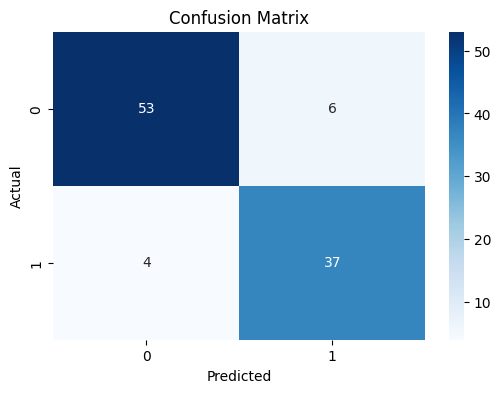

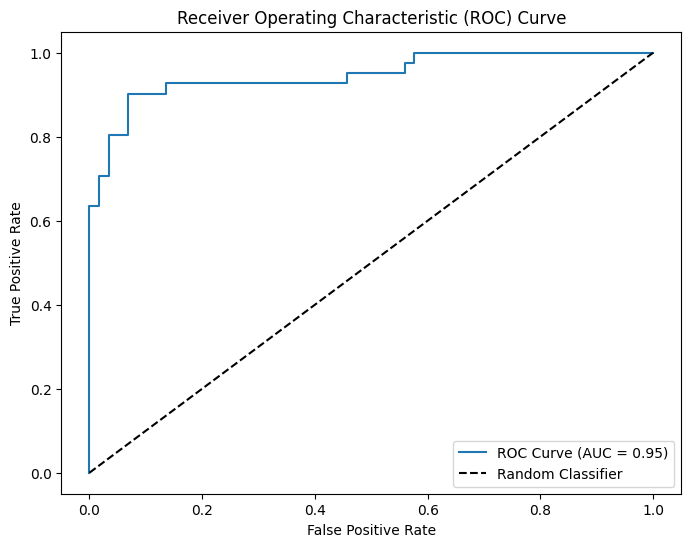

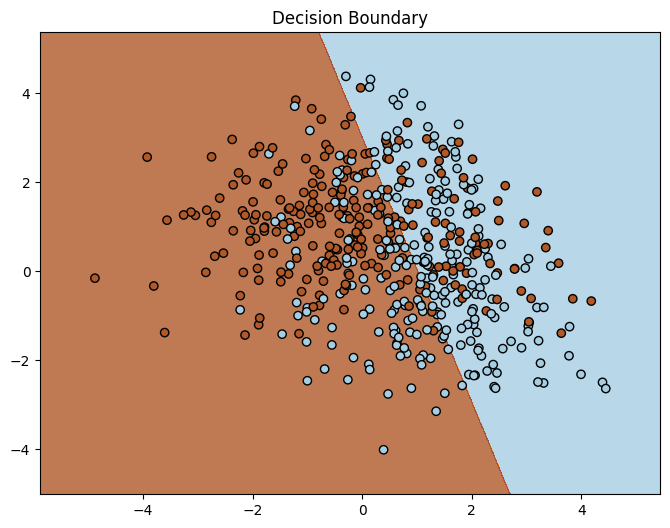

In [23]:
# 예측
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# 성능 출력
print("Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_lr))

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC 곡선 및 AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
roc_auc = roc_auc_score(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# 결정 경계 시각화
# 여기도 피처 2개로 설정되어있어서 7개로 변경
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
input_features = np.c_[xx.ravel(), yy.ravel()]  # (n_samples, 2)

# 나머지 5개의 피처를 0으로 채워서 입력 데이터 조정 (7개의 피처)
adjusted_input_features = np.hstack([input_features, np.zeros((input_features.shape[0], 5))])  # (n_samples, 7)


Z = lr_model.predict(adjusted_input_features)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Paired)
plt.title("Decision Boundary")
plt.show()


In [ ]:
import pickle

# 모델 저장
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

# 스케일러 저장 pkl로 저장
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)